In [1]:
import time
import bs4
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

In [2]:
data_dict={
    'Season':[],
    'Round':[],
    'Team_1':[],
    'Team_2':[],
    'Team_1_Score':[],
    'Team_2_Score':[],
    'Team_1_Seed':[],
    'Team_2_Seed':[],
}
region_list = ['east', 'west', 'midwest', 'south', 'national']
year_list = ['2010', '2012', '2013', '2014', '2015', '2016', '2017','2018', '2019', '2021', '2022', '2023', '2024']
for year in year_list:
    url = f'https://www.sports-reference.com/cbb/postseason/{year}-ncaa.html'
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome('C:\Program Files\ChromeDriver\chromedriver.exe',options=options)
    driver.get(url)
    time.sleep(2)
    page = driver.page_source
    soup = bs4.BeautifulSoup(page, 'html.parser')
    driver.quit()
    for region in region_list:
        rounds = soup.find('div', {'id':'brackets'}).find('div', {'id':region}).find_all('div', {'class':'round'})
        rounds_cnt = 1
        if region=='national':
            rounds_cnt=5
        for round in rounds:
            games = round.find_all('div')
            for i in range(len(games)):
                data = games[i].get_text().replace('\n', ' ').split(' at ')[0].split()
                if len(data) > 5:
                    data_dict['Season'].append(year)
                    data_dict['Round'].append(rounds_cnt)
                    team1 = ' '.join([x for x in data[:3] if x.isalpha()])
                    team2 = ' '.join([x for x in data[3:] if x.isalpha()])
                    num_list = [x for x in data if x.isnumeric()]
                    team_1_seed = int(num_list[0])
                    team_2_seed = int(num_list[2])
                    team_1_score = int(num_list[1])
                    team_2_score = int(num_list[3])
                    if team_2_seed < team_1_seed:
                        temp = team1
                        temp_seed = team_1_seed
                        temp_score = team_1_score
                        team1 = team2
                        team_1_seed = team_2_seed
                        team_1_score = team_2_score
                        team2 = temp
                        team_2_seed = temp_seed
                        team_2_score = temp_score

                    data_dict['Team_1'].append(team1)
                    data_dict['Team_2'].append(team2)

                    data_dict['Team_1_Seed'].append(team_1_seed)
                    data_dict['Team_2_Seed'].append(team_2_seed)

                    data_dict['Team_1_Score'].append(team_1_score)
                    data_dict['Team_2_Score'].append(team_2_score)

            rounds_cnt+=1
    time.sleep(10)

tournament_results = pd.DataFrame.from_dict(data_dict)
tournament_results.to_csv('ncaa_tournament_results_10_24.csv', index=False)
tournament_results

,Season,Round,Team_1,Team_2,Team_1_Score,Team_2_Score,Team_1_Seed,Team_2_Seed
0,2010,1,Kentucky,ETSU,100,71,1,16
1,2010,1,Texas,Wake Forest,80,81,8,9
2,2010,1,Temple,Cornell,65,78,5,12
3,2010,1,Wisconsin,Wofford,53,49,4,13
4,2010,1,Marquette,Washington,78,80,6,11
...,...,...,...,...,...,...,...,...
813,2024,3,Marquette,NC State,58,67,2,11
814,2024,4,Duke,NC State,64,76,4,11
815,2024,5,UConn,Alabama,86,72,1,4
816,2024,5,Purdue,NC State,63,50,1,11


In [3]:
df_list = []
#year_list = ['2017','2018', '2019', '2021']
for year in year_list:
    basic = pd.read_html(f'https://www.sports-reference.com/cbb/seasons/{year}-school-stats.html')[0]
    subset = basic['Conf.']
    subset = subset.replace({'W':0,'L':0, 'Conf.':0})
    subset = subset.astype('float')
    conf_pct = subset['W']/(subset['W']+subset['L'])
    basic = basic.droplevel(0, axis=1)
    col_list = list(basic.columns[1:8]) + list(basic.columns[-20:-18]) + list(basic.columns[-17:])
    basic = basic[col_list]
    basic = basic.loc[:,~basic.columns.duplicated()]
    basic = basic.dropna()
    basic.insert(5,'Conf. Pct', conf_pct)

    advanced = pd.read_html(f'https://www.sports-reference.com/cbb/seasons/{year}-advanced-school-stats.html')[0]
    subset = advanced['School Advanced']
    subset.insert(0,'School', advanced.droplevel(0, axis=1)['School'])
    basic = basic.loc[basic['School']!='School',:]
    basic.iloc[:,1:] = basic.iloc[:,1:].astype('float')
    for column in basic.columns[4:]:
        if basic[column].mean()>1 and '%' not in column:
            basic[column] = basic[column]/basic['G']

    final = basic.merge(subset, on='School')
    final = final.loc[final['School']!='School',:]
    final.iloc[:,1:] = final.iloc[:,1:].astype('float')
    
    final.insert(0,'Season', year)
    df_list.append(final.copy())
    time.sleep(10)

final = pd.concat(df_list).reset_index(drop=True)
final = final[final['School'].str.contains('NCAA')]
final['School']=final['School'].str.strip().str.replace('NCAA', '').str.strip()
df_list = []
for year in year_list:
    df = final.loc[final['Season']==year]
    scaled = StandardScaler().fit_transform(df[df.columns[2:]])
    df = pd.DataFrame(scaled, index=df.index, columns=df.columns[2:])
    df.insert(0,'School', final[final['Season']==year]['School'].copy())
    df.insert(0,'Season', final[final['Season']==year]['Season'].copy())
    df_list.append(df.copy())
final = pd.concat(df_list)
final.to_csv('ncaa_season_stats_10_24.csv', index=False)

final


,Season,School,G,W,L,W-L%,Conf. Pct,SRS,SOS,Tm.,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
13,2010,Arkansas-Pine Bluff,-0.374750,-1.900291,2.264753,-2.258179,0.301623,-2.545798,-2.208174,-2.118132,...,-1.376417,-2.033895,0.979681,0.546904,-0.418390,-0.098319,-2.333294,2.560876,0.237020,1.308283
18,2010,Baylor,0.758215,0.662342,-0.417870,0.521396,-0.356523,0.842551,0.822697,0.650001,...,0.110375,1.182267,1.072171,-0.710330,-0.476749,2.310763,1.235273,0.622110,0.992998,-0.366957
27,2010,Brigham Young,0.758215,1.174868,-1.088526,1.135358,0.554756,0.952228,-0.147722,1.930932,...,0.228374,1.787662,0.424742,0.036722,0.807152,-0.466374,1.340231,-0.984297,-0.909980,0.882825
31,2010,Butler,1.891180,1.943658,-1.423854,1.526061,1.921675,0.378040,0.253564,-1.073871,...,1.833166,0.387686,0.008538,-0.036161,0.223560,-1.336320,-0.129179,0.178963,-1.118526,1.919879
35,2010,California,0.191733,-0.362711,0.588113,-0.505596,-0.103390,0.754811,0.867070,0.703491,...,-0.479622,0.841732,0.193517,-0.601005,-1.293778,-1.403239,0.675498,-0.485757,0.002406,-0.154228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,2024,Wagner,-1.501294,-2.111546,1.739697,-2.048556,-1.788871,-2.441388,-2.169899,-2.574747,...,0.132256,-2.902219,-0.841779,0.233438,-0.372038,-1.130597,-2.610810,-0.352436,-0.321568,-1.758357
4546,2024,Washington State,-0.209041,0.039542,-0.148059,0.125304,0.126280,0.297071,0.469701,-0.697587,...,-1.024327,-0.557136,0.803318,-1.490413,-1.242528,0.982152,-0.376728,0.209808,0.361764,-0.620424
4551,2024,Western Kentucky,-0.855167,-0.767116,0.481193,-0.606599,-1.332883,-1.127682,-1.220848,0.582293,...,-1.044268,-0.354973,-0.082503,-1.544283,0.063206,-0.543722,-0.302258,1.615419,-0.557199,-0.250596
4556,2024,Wisconsin,0.437085,-0.767116,1.110445,-0.999860,-0.968092,0.518058,1.166006,-0.482666,...,-0.366271,-0.031514,0.001861,-1.095364,-0.372038,-2.147846,-0.227789,-0.492997,-0.274441,0.318370


In [18]:
final=pd.read_csv('ncaa_season_stats_10_24.csv')

In [19]:
final

,Season,School,G,W,L,W-L%,Conf. Pct,SRS,SOS,Tm.,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,2010,Arkansas-Pine Bluff,-0.374750,-1.900291,2.264753,-2.258179,0.301623,-2.545798,-2.208174,-2.118132,...,-1.376417,-2.033895,0.979681,0.546904,-0.418390,-0.098319,-2.333294,2.560876,0.237020,1.308283
1,2010,Baylor,0.758215,0.662342,-0.417870,0.521396,-0.356523,0.842551,0.822697,0.650001,...,0.110375,1.182267,1.072171,-0.710330,-0.476749,2.310763,1.235273,0.622110,0.992998,-0.366957
2,2010,Brigham Young,0.758215,1.174868,-1.088526,1.135358,0.554756,0.952228,-0.147722,1.930932,...,0.228374,1.787662,0.424742,0.036722,0.807152,-0.466374,1.340231,-0.984297,-0.909980,0.882825
3,2010,Butler,1.891180,1.943658,-1.423854,1.526061,1.921675,0.378040,0.253564,-1.073871,...,1.833166,0.387686,0.008538,-0.036161,0.223560,-1.336320,-0.129179,0.178963,-1.118526,1.919879
4,2010,California,0.191733,-0.362711,0.588113,-0.505596,-0.103390,0.754811,0.867070,0.703491,...,-0.479622,0.841732,0.193517,-0.601005,-1.293778,-1.403239,0.675498,-0.485757,0.002406,-0.154228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,2024,Wagner,-1.501294,-2.111546,1.739697,-2.048556,-1.788871,-2.441388,-2.169899,-2.574747,...,0.132256,-2.902219,-0.841779,0.233438,-0.372038,-1.130597,-2.610810,-0.352436,-0.321568,-1.758357
877,2024,Washington State,-0.209041,0.039542,-0.148059,0.125304,0.126280,0.297071,0.469701,-0.697587,...,-1.024327,-0.557136,0.803318,-1.490413,-1.242528,0.982152,-0.376728,0.209808,0.361764,-0.620424
878,2024,Western Kentucky,-0.855167,-0.767116,0.481193,-0.606599,-1.332883,-1.127682,-1.220848,0.582293,...,-1.044268,-0.354973,-0.082503,-1.544283,0.063206,-0.543722,-0.302258,1.615419,-0.557199,-0.250596
879,2024,Wisconsin,0.437085,-0.767116,1.110445,-0.999860,-0.968092,0.518058,1.166006,-0.482666,...,-0.366271,-0.031514,0.001861,-1.095364,-0.372038,-2.147846,-0.227789,-0.492997,-0.274441,0.318370


Text(0.5, 1.0, 'Kernel Density Estimate for FG per Game')

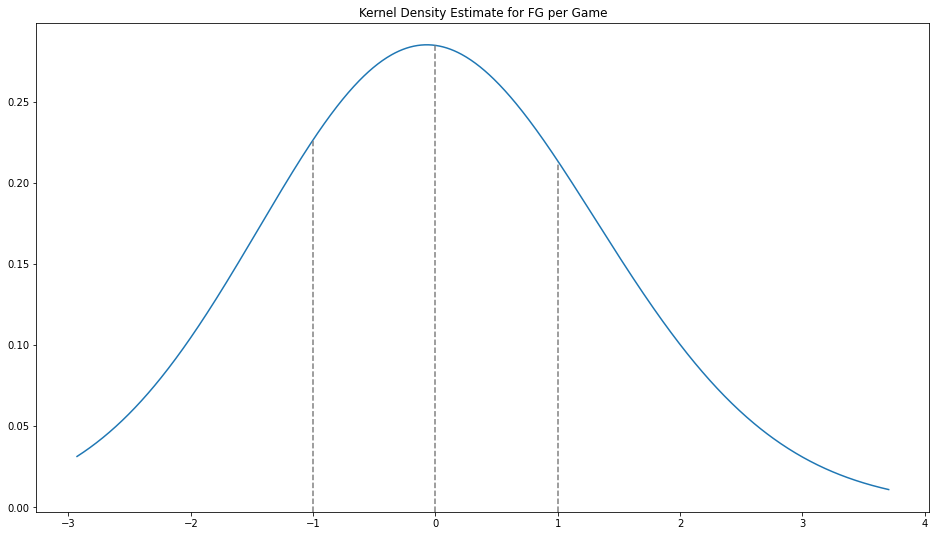

In [16]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

fig, ax = plt.subplots(figsize=(16,9))
target_col = 'FG'
kde = KernelDensity().fit(final[target_col].reset_index(drop=True).to_numpy().reshape(-1,1))
X_plot = np.linspace(final[target_col].min(),final[target_col].max(),len(final[target_col]))[:,np.newaxis]
log_dens = kde.score_samples(X_plot)

ax.plot(X_plot[:,0], np.exp(log_dens))
col_mean = final[target_col].mean()
col_std = final[target_col].std()
ax.axvline(col_mean, ymax=np.exp(log_dens).max()/ax.get_ylim()[1], color='gray', linestyle='dashed')
ax.axvline(col_mean-col_std, ymax=np.interp(col_mean-col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
ax.axvline(col_mean+col_std, ymax=np.interp(col_mean+col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
ax.set_title(f'Kernel Density Estimate for {target_col} per Game')

In [22]:
print("Years in year_list:", year_list)
print("\nYears in final['Season']:", sorted(final['Season'].astype('string').unique()))
print("\nMissing years:", set(year_list) - set(final['Season'].unique()))

Years in year_list: ['2010', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2021', '2022', '2023', '2024']

Years in final['Season']: ['2010', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2021', '2022', '2023', '2024']

Missing years: {'2023', '2013', '2015', '2014', '2012', '2010', '2018', '2019', '2022', '2024', '2021', '2017', '2016'}


In [24]:
year

'2010'

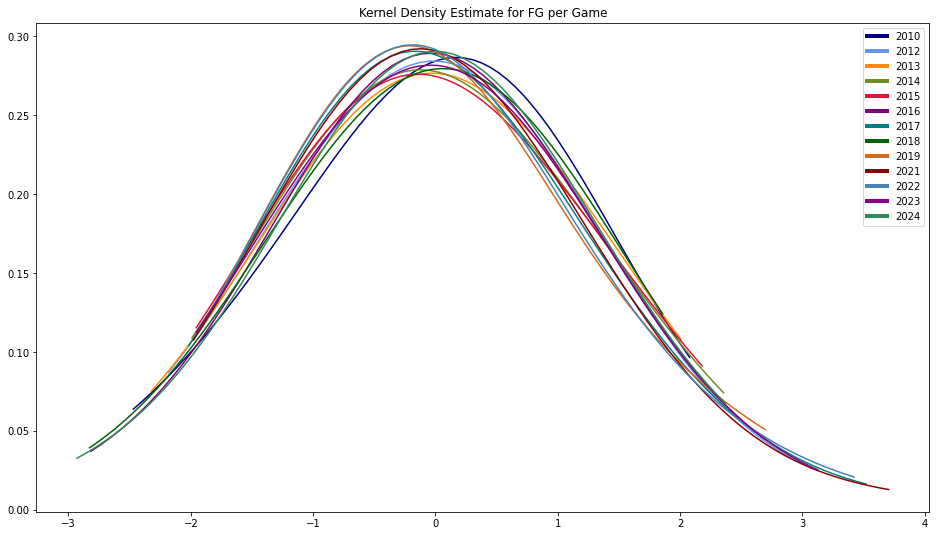

In [25]:
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
color_list = ['navy', 'cornflowerblue', 'darkorange', 'olivedrab', 'crimson', 'purple', 'teal', 'darkgreen', 'chocolate', 'darkred', 'steelblue', 'darkmagenta', 'seagreen']
fig, ax = plt.subplots(figsize=(16,9))
legend_elements = []

for i, year in enumerate(year_list):
    series = final.loc[final['Season']==int(year), target_col].to_numpy().reshape(-1,1)
    kde = KernelDensity().fit(series)
    X_plot = np.linspace(series.min(),series.max(),len(series))[:,np.newaxis]
    log_dens = kde.score_samples(X_plot)

    ax.plot(X_plot[:,0], np.exp(log_dens), color=color_list[i])
    col_mean = series.mean()
    col_std = series.std()
    # ax.axvline(col_mean, ymax=np.exp(log_dens).max()/ax.get_ylim()[1], color='gray', linestyle='dashed')
    # ax.axvline(col_mean-col_std, ymax=np.interp(col_mean-col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
    # ax.axvline(col_mean+col_std, ymax=np.interp(col_mean+col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
    legend_elements.append(Line2D([0], [0], color=color_list[i], lw=4, label=str(year)))

ax.set_title(f'Kernel Density Estimate for {target_col} per Game')
ax.legend(handles=legend_elements)

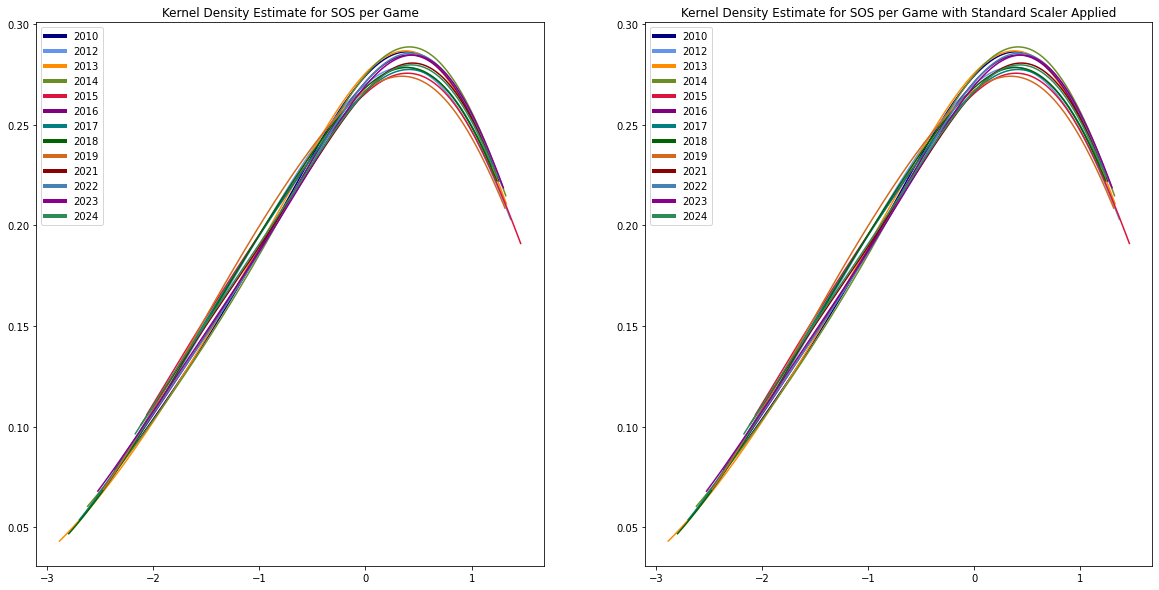

In [27]:

target_col = 'SOS'
#color_list = ['navy', 'cornflowerblue', 'darkorange', 'olivedrab']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes_list = [ax for ax in axes.flat]
legend_elements = []
ax = axes_list[1]
for i, year in enumerate(year_list):
    series = final.loc[final['Season']==int(year), target_col]
    series = StandardScaler().fit(series.to_numpy().reshape(-1,1)).transform(series.to_numpy().reshape(-1,1))
    kde = KernelDensity().fit(series)
    X_plot = np.linspace(series.min(),series.max(),1000)[:,np.newaxis]
    log_dens = kde.score_samples(X_plot)

    ax.plot(X_plot[:,0], np.exp(log_dens), color=color_list[i])
    col_mean = series.mean()
    col_std = series.std()
    # ax.axvline(col_mean, ymax=np.exp(log_dens).max()/ax.get_ylim()[1], color='gray', linestyle='dashed')
    # ax.axvline(col_mean-col_std, ymax=np.interp(col_mean-col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
    # ax.axvline(col_mean+col_std, ymax=np.interp(col_mean+col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
    legend_elements.append(Line2D([0], [0], color=color_list[i], lw=4, label=str(year)))

ax.set_title(f'Kernel Density Estimate for {target_col} per Game with Standard Scaler Applied')
ax.legend(handles=legend_elements)

legend_elements = []
ax=axes_list[0]

for i, year in enumerate(year_list):
    series = final.loc[final['Season']==int(year), target_col].to_numpy().reshape(-1,1)
    kde = KernelDensity().fit(series)
    X_plot = np.linspace(series.min(),series.max(),1000)[:,np.newaxis]
    log_dens = kde.score_samples(X_plot)

    ax.plot(X_plot[:,0], np.exp(log_dens), color=color_list[i])
    col_mean = series.mean()
    col_std = series.std()
    # ax.axvline(col_mean, ymax=np.exp(log_dens).max()/ax.get_ylim()[1], color='gray', linestyle='dashed')
    # ax.axvline(col_mean-col_std, ymax=np.interp(col_mean-col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
    # ax.axvline(col_mean+col_std, ymax=np.interp(col_mean+col_std, X_plot[:,0], np.exp(log_dens))/ax.get_ylim()[1], color='gray', linestyle='dashed')
    legend_elements.append(Line2D([0], [0], color=color_list[i], lw=4, label=str(year)))

ax.set_title(f'Kernel Density Estimate for {target_col} per Game')
ax.legend(handles=legend_elements)

In [28]:
tournament_results['Season'] = tournament_results['Season'].astype('int')
final['Season'] = final['Season'].astype('int')

school_replace_dict = {
    'Southern Methodist':'SMU',
    'North Carolina':'UNC',
    'Miami (FL)':'Miami',
    'Saint Mary\'s (CA)':'Saint',
    'Maryland-Baltimore County':'UMBC',
    'Loyola (IL)':'Loyola',
    'Virginia Commonwealth':'VCU',
    'Louisiana State': 'LSU',
    'Mississippi':'Ole Miss',
    'Brigham Young':'BYU',
    'Connecticut': 'UConn',
    'Southern California' :'USC',
    'East Tennessee State':'ETSU',
    'Mount St. Mary\'s':'Mount',
    'St. Bonaventure':'Bonaventure',
    'Stephen F. Austin':'Stephen Austin',
    'Pennsylvania':'Penn',
    'Central Florida':'UCF',
    'UC Santa Barbara':'UCSB'  
}

final['School']=final['School'].replace(school_replace_dict)

tournament_results.iloc[30,3]='UC Davis'
tournament_results.iloc[171,3]='Gardner-Webb'
tournament_results.iloc[174,3]='UC Irvine'
tournament_results.iloc[180,3]='UC Irvine'
tournament_results['Team_2']=tournament_results['Team_2'].replace({'State Syracuse':'Syracuse'})

series_2=tournament_results.loc[tournament_results['Team_1_Seed']>tournament_results['Team_2_Seed'],'Team_1'].append(tournament_results.loc[tournament_results['Team_1_Seed']<tournament_results['Team_2_Seed'],'Team_2'])
series_1=tournament_results.loc[tournament_results['Team_1_Seed']>tournament_results['Team_2_Seed'],'Team_2'].append(tournament_results.loc[tournament_results['Team_1_Seed']<tournament_results['Team_2_Seed'],'Team_1'])

tournament_results['Team_1']=series_2
tournament_results['Team_2']=series_1

seeds = tournament_results.copy()
tournament_results = tournament_results[tournament_results['Season'].isin(final['Season'].unique())]

modeling_df = tournament_results.merge(final, left_on=['Season', 'Team_1'], right_on=['Season', 'School'], how='left')
modeling_df = modeling_df.drop(columns='School').rename(columns={col : col+'_1' for col in modeling_df.columns[8:]})
modeling_df = modeling_df.merge(final, left_on=['Season', 'Team_2'], right_on=['Season', 'School'], how='left')
modeling_df = modeling_df.drop(columns='School').rename(columns={col : col+'_2' for col in modeling_df.columns[48:]})

modeling_df.insert(4, 'Win',modeling_df['Team_1_Score']>modeling_df['Team_2_Score'])

modeling_df.to_csv('ncaa_tournament_modeling_df.csv', index=False)

In [29]:
modeling_df

,Season,Round,Team_1,Team_2,Win,Team_1_Score,Team_2_Score,Team_1_Seed,Team_2_Seed,G_1,...,3PAr_2,TS%_2,TRB%_2,AST%_2,STL%_2,BLK%_2,eFG%_2,TOV%_2,ORB%_2,FT/FGA_2
0,2010,1,ETSU,Kentucky,True,100,71,1,16,0.191733,...,-0.172824,0.425523,1.534621,-0.236590,-0.068235,2.444600,0.570540,0.400536,1.514361,0.457367
1,2010,1,Wake Forest,Texas,False,80,81,8,9,-2.074197,...,-1.376417,-0.482570,0.794702,-1.165850,0.048483,0.838546,-0.094193,-0.374970,1.097270,-0.420140
2,2010,1,Cornell,Temple,False,65,78,5,12,-0.374750,...,-0.196424,-1.163639,0.332252,0.984202,-1.760651,-0.800968,-0.793912,-1.095083,-0.675367,-2.254927
3,2010,1,Wofford,Wisconsin,True,53,49,4,13,0.191733,...,1.738766,-0.028523,-0.361422,-0.364135,-0.651827,-0.332536,0.010765,-1.925983,-1.170662,-0.951962
4,2010,1,Washington,Marquette,False,78,80,6,11,0.758215,...,0.723972,0.576872,-1.425056,0.874878,0.923870,-1.670915,0.500568,-1.205870,-0.909980,-0.393549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2024,3,NC State,Marquette,False,58,67,2,11,3.667717,...,0.750430,0.413244,-1.938510,0.053870,1.260129,0.199652,0.814783,-0.703839,-1.334783,-1.815254
814,2024,4,NC State,Duke,False,64,76,4,11,3.667717,...,0.032551,0.615406,0.550227,0.125697,-0.154416,-0.113347,0.665844,-0.914680,0.173258,0.119232
815,2024,5,Alabama,UConn,True,86,72,1,4,1.083212,...,0.570960,1.464488,1.646958,1.687938,-0.372038,1.608151,1.522243,-0.984961,1.257163,-0.193700
816,2024,5,NC State,Purdue,True,63,50,1,11,3.667717,...,-0.525800,1.221893,2.364052,1.921376,-1.133716,-0.308972,1.112661,0.209808,1.492795,1.513200


In [30]:
seeds['Seed_Diff']=seeds['Team_2_Seed']-seeds['Team_1_Seed']
seeds['Seed_Diff'].describe()

count    818.000000
mean       6.480440
std        4.177545
min        0.000000
25%        3.000000
50%        7.000000
75%        9.000000
max       15.000000
Name: Seed_Diff, dtype: float64

In [57]:
seeds

,Season,Round,Team_1,Team_2,Team_1_Score,Team_2_Score,Team_1_Seed,Team_2_Seed,Seed_Diff
378,2017,1,Villanova,Mount,76,56,1,16,15
379,2017,1,Wisconsin,Virginia Tech,84,74,8,9,1
380,2017,1,Virginia,UNC Wilmington,76,71,5,12,7
381,2017,1,Florida,ETSU,80,65,4,13,9
382,2017,1,SMU,USC,65,66,6,11,5
...,...,...,...,...,...,...,...,...,...
624,2021,3,Arkansas,Oral Roberts,72,70,3,15,12
625,2021,4,Baylor,Arkansas,81,72,1,3,2
626,2021,5,Baylor,Houston,78,59,1,2,1
627,2021,5,Gonzaga,UCLA,93,90,1,11,10


In [58]:
seeds['Win'] = seeds['Team_1_Score']>seeds['Team_2_Score']
test = seeds[['Season', 'Seed_Diff', 'Win']].groupby(['Season', 'Seed_Diff'], as_index=False).agg('sum')
test['n']=seeds[['Season','Seed_Diff', 'Win']].groupby(['Season','Seed_Diff'], as_index=False).agg('count').iloc[:,-1]
test['pct']=(test['Win']/test['n']).fillna(0)
test2 = test[['Seed_Diff', 'Win']].groupby('Seed_Diff', as_index=False).agg('sum')
test2['n'] = test[['Seed_Diff', 'n']].groupby('Seed_Diff', as_index=False).agg('sum').iloc[:,1]
test2['std']=test[['Seed_Diff', 'pct']].groupby('Seed_Diff', as_index=False).agg('std').iloc[:,1]
test2['Pct']=test2['Win']/test2['n']
test2.to_csv('seed_diff_table.csv')

In [59]:
series = seeds[['Season', 'Seed_Diff', 'Win']].groupby(['Season', 'Seed_Diff'], as_index=False).agg('sum').iloc[:,-1]/seeds[['Season', 'Seed_Diff', 'Win']].groupby(['Season', 'Seed_Diff'], as_index=False).agg('count').iloc[:,-1]